# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import uuid
import PIL
from tqdm import tqdm

# Loading CIFAR10 dataset

In [2]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform_test)

batch_size = 128

c, w, h = 3, 32, 32

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)

# Loading MobileNetV2 model

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

# Replace the final fully-connected layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))

error = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Training

In [6]:
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights

In [7]:
start=time.time()

for epoch in range(0,200):

    model.train()  # Put the network in train mode
    for i, (x_batch, y_batch) in enumerate(trainloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

        optimizer.zero_grad()  # Set all currenly stored gradients to zero 

        y_pred = model(x_batch)

        loss = error(y_pred, y_batch)

        loss.backward()

        optimizer.step()

        # Compute relevant metrics

        y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

        correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

        elapsed = time.time() - start  # Keep track of how much time has elapsed

        # Show progress every 20 batches 
        if not i % 20:
            print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')
    
    correct_total = 0

    model.eval()  # Put the network in eval mode
    for i, (x_batch, y_batch) in enumerate(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

        y_pred = model(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')
    
    # Save weights every 10 epochs
    if epoch%10==0:
        torch.save(model.state_dict(), f"./weights/epoch-{epoch}_accuracy-{correct_total/len(testset):.3f}.pth")

epoch: 0, time: 3.109s, loss: 2.396, train accuracy: 0.086
epoch: 0, time: 4.491s, loss: 2.289, train accuracy: 0.141
epoch: 0, time: 5.749s, loss: 2.415, train accuracy: 0.141
epoch: 0, time: 7.004s, loss: 2.176, train accuracy: 0.148
epoch: 0, time: 8.248s, loss: 2.157, train accuracy: 0.195
epoch: 0, time: 9.491s, loss: 2.172, train accuracy: 0.219
epoch: 0, time: 10.737s, loss: 2.027, train accuracy: 0.211
epoch: 0, time: 11.978s, loss: 2.033, train accuracy: 0.227
epoch: 0, time: 13.226s, loss: 2.073, train accuracy: 0.234
epoch: 0, time: 14.473s, loss: 1.925, train accuracy: 0.297
epoch: 0, time: 15.712s, loss: 1.895, train accuracy: 0.305
epoch: 0, time: 16.948s, loss: 1.898, train accuracy: 0.250
epoch: 0, time: 18.193s, loss: 1.796, train accuracy: 0.297
epoch: 0, time: 19.433s, loss: 1.891, train accuracy: 0.312
epoch: 0, time: 20.676s, loss: 1.781, train accuracy: 0.344
epoch: 0, time: 21.922s, loss: 1.830, train accuracy: 0.359
epoch: 0, time: 23.163s, loss: 1.921, train ac

# Load latest weights

In [5]:
files = os.listdir('./weights')
weight_paths = [os.path.join('weights', basename) for basename in files]
final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

# Replace the final fully-connected layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
model.to(device)

model.load_state_dict(torch.load(os.path.join('weights', final_weight_file), map_location=device))
print('Loaded weights: ' + final_weight_file)

# sets the module in eval node
model.eval()

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded weights: epoch-190_accuracy-0.840.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Evaluation

In [6]:
correct_total = 0
for i, (x_batch, y_batch) in enumerate(testloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = model(x_batch)
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.840


In [7]:
def show(X):
    X = inverse_transform(X)

    plt.imshow(np.transpose(X.numpy(), (1, 2, 0)))
    plt.show()
    
inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


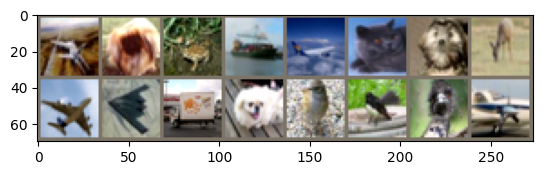

GroundTruth:  plane dog   frog  ship  plane cat   dog   deer  plane plane truck dog   bird  bird  bird  plane
Predicted:  plane dog   frog  ship  plane cat   frog  deer  plane plane truck dog   bird  bird  bird  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show(torchvision.utils.make_grid(images[:16]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))

In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 83.6 %
Accuracy for class: car   is 92.3 %
Accuracy for class: bird  is 81.7 %
Accuracy for class: cat   is 64.0 %
Accuracy for class: deer  is 82.9 %
Accuracy for class: dog   is 79.9 %
Accuracy for class: frog  is 86.7 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 91.0 %
Accuracy for class: truck is 91.0 %


# Adversarial attack

In [112]:
import numpy as np

class GeneticSolver:
    def __init__(self, image_size, population_size=100, n_generations=1000, retain_best=0.8, retain_random=0.05, mutate_chance=0.05,
                 verbosity=0, verbose_step=50, random_state=None, warm_start=False, early_stopping=True, patience=20):
        """
        :param population_size: number of individual candidate solutions
        :param n_generations: number of generations
        :param retain_best: percentage of best candidates to select into the next generation
        :param retain_random: probability of selecting sub-optimal candidate into the next generation
        :param mutate_chance: candidate mutation chance
        :param verbosity: level of verbosity (0 - quiet, 1 - evolution information, 2 - spamming like it's 2003)
        :param verbosity_step: number of generations to process before showing the best score
        :param random_state: if specified, initializes seed with this value
        :param warm_start: if True, initial population generation step is omitted, allowing for continuing training
        :param early_stopping: if True, evolution will stop if top-10 candidates are not changing for several generations
        :param patience: number of generations to wait for best solution change when <early_stopping>
        """
        self.image_size = image_size
        self.population_size = population_size
        self.n_generations = n_generations
        self.retain_best = retain_best
        self.retain_random = retain_random
        self.mutate_chance = mutate_chance
        self.verbosity = verbosity
        self.verbosity_step = verbose_step
        self.random_state = random_state
        self.warm_start = warm_start
        self.early_stopping = early_stopping
        self.patience = patience

        self._population = None

    def solve(self, fitness_fn, n_generations=-1, verbose_step=None):
        """
        :param fitness_fn: function to optimize w.r.t.
        :param n_generations: number of evolution generations. Overrides initialization value if specified
        :return: best gene from the population pool. You can still have access to population and the corresponding scores afterwards
        """
        if verbose_step is None:
            verbose_step = self.verbose_step
        if self.random_state is not None:
            np.random.seed(self.random_state)
        if self._population is None or self.warm_start:
            self._population = self._generate_population(self.image_size)
    
        if n_generations != -1:
            self.n_generations = n_generations
    
        scores = np.zeros(len(self._population))
        prev_scores = np.zeros(len(self._population))
        cnt_no_change_in_scores = 0

        for generation in range(self.n_generations):
            self._population, scores = self.evolve(fitness_fn)
            if np.isclose(prev_scores[:10], scores[:10]).all():
                cnt_no_change_in_scores += 1
            else:
                cnt_no_change_in_scores = 0
                prev_scores = scores
            
            if self.verbosity:
                if generation == 0:
                    print("Generation #: best score")
                elif generation == self.n_generations - 1:
                    print("Generation ",generation,": ",scores[0])
                elif generation % verbose_step == 0:
                    print("Generation ",generation,": ",scores[0])
                    
            if np.isclose(scores[:10], 1).any() or (self.early_stopping and cnt_no_change_in_scores >= self.patience):
                if self.verbosity:
                    print("Early stopping on generation ",generation, " with best score ", scores[0])
                break

        return self._population[0], scores[0]

    def _generate_population(self, image_size):
        """
        Generating initial population of individual solutions
        :return: initial population as an array
        """
        return np.random.rand(self.population_size, *image_size)

    def evolve(self, fitness_fn):
        """
        Evolution step
        :return: new generation of the same size along with scores of the best retained individuals
        """
        scores = np.array(self.score_population(self._population, fitness_fn))
        
        retain_len = int(len(scores) * self.retain_best)
        sorted_indices = np.argsort(scores)[::-1]
        self._population = [self._population[idx] for idx in sorted_indices]
        best_scores = scores[sorted_indices][:retain_len]
        if self.verbosity > 1:
            print("best scores:", best_scores)
        parents = self._population[:retain_len]
        leftovers = self._population[retain_len:]

        cnt_degenerate = 0
        for gene in leftovers:
            if np.random.rand() < self.retain_random:
                cnt_degenerate += 1
                parents.append(gene)
        if self.verbosity > 1:
            print("# of degenerates left: ", cnt_degenerate)

        cnt_mutations = 0
        for gene in parents[1:]:  # mutate everyone expecting for the best candidate
            if np.random.rand() < self.mutate_chance:
                self.mutate(gene, self.image_size)
                cnt_mutations += 1
        if self.verbosity > 1:
            print("# of mutations: ", cnt_mutations)

        places_left = self.population_size - retain_len
        children = []
        while len(children) < places_left:
            mom_idx, dad_idx = np.random.randint(0, retain_len - 1, 2)
            if mom_idx != dad_idx:
                child1, child2 = self.crossover(parents[mom_idx], parents[dad_idx], self.image_size)
                children.append(child1)
                if len(children) < places_left:
                    children.append(child2)
        if self.verbosity > 1:
            print("# of children: ", len(children))
        parents.extend(children)
        return parents, best_scores

    @classmethod
    def crossover(cls, mom, dad, image_size):
        """
        Take two parents, return two children, interchanging half of the allels of each parent randomly
        """
        # select_mask = np.random.randint(0, 2, size=(20, 20), dtype='bool')
        select_mask = np.random.binomial(1, 0.5, size=image_size).astype('bool')
        child1, child2 = np.copy(mom), np.copy(dad)
        child1[select_mask] = dad[select_mask]
        child2[select_mask] = mom[select_mask]
        return child1, child2

    @classmethod
    def mutate(cls, field, image_size):
        """
        Inplace mutation of the provided field
        """
        a = np.random.binomial(1, 0.1, size=image_size).astype('bool')
        field[a] = np.clip(field[a] + np.random.randn(*field[a].shape) * 0.1, 0, 1)
        return field

    @classmethod
    def score_population(cls, population, fitness_function):
        """
        Apply fitness function for each gene in a population
        :param population: list of candidate solutions (images)
        :return: list/1d-array of scores for each solution
        """
        if type(population) is list:
            population = np.array(population)
            
        return fitness_function(population)

In [181]:
def fitness_class_probability_empty(X):
    """ Maximize probability of adversarial target class, penalizing mean pixel intensity"""
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    X_mean = X.mean(axis=1).mean(axis=1).mean(axis=1)
    return y_target - X_mean

In [114]:
def show_probabilities(X):
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
    prob = F.softmax(model(X.unsqueeze(0).to(device)), dim=1)

    print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())]))    
    print('\nLabel with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))

## Attack with a single sample

In [256]:
adv_target = classes.index('frog')
m = GeneticSolver(image_size=image_size, verbosity=True, verbose_step=100, warm_start=True, random_state=42, early_stopping=False)
res, score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)

Generation #: best score
Generation  500 :  16.64337788783132
Generation  999 :  17.394771363255803


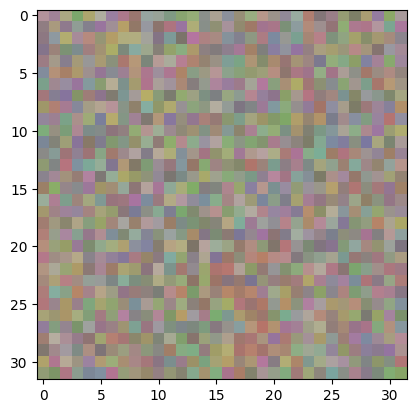

Confidence scores:
plane: 9.209055711327887e-24
car: 1.8352561765293533e-25
bird: 2.0074374020712105e-12
cat: 3.4401385531874313e-15
deer: 1.0933132567400463e-18
dog: 1.931635766323856e-15
frog: 1.0
horse: 9.284237228997536e-21
ship: 7.525056508696135e-22
truck: 1.8576779749688307e-23

Label with highest confidence score: frog


In [257]:
show(torch.Tensor(res))
show_probabilities(res)

## Generating a dataset of adversarial examples

In [123]:
generate_adversarial_dataset = True

if generate_adversarial_dataset:
    if os.path.exists(os.path.join('adversarial_dataset')):
        shutil.rmtree(os.path.join('adversarial_dataset'))
    !mkdir adversarial_dataset

In [258]:
# set parameters for the dataset
batch_size = 128
num_batches = 10

In [ ]:
# the loop below takes around 1-2 days to run :)

In [262]:
for aClass in classes:
    print('Generating adversarial examples for class: ' + aClass)
    
    for batch_num in range(num_batches):
        print('Batch: ' + str(batch_num+1) + ' out of ' + str(num_batches))
        batch_list = [0]*batch_size
        for i in tqdm(range(0,batch_size)):
            adv_target = classes.index(aClass)
            m = GeneticSolver(image_size=image_size, verbosity=False, verbose_step=100, warm_start=True, random_state=42, early_stopping=False)
            batch_list[i], score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)

        # Create a tensor to hold the res tensors
        batch = torch.zeros([batch_size, 3, 32, 32])

        # Loop over the res tensors and concatenate them into the batch tensor
        for i, bat in enumerate(batch_list):
            batch[i] = torch.Tensor(bat)

        torch.save(batch, os.path.join('adversarial_dataset', aClass + '_' + str(batch_num) + '.pt'))

Generating adversarial examples for class: plane
Batch: 1 out of 10


 29%|███████████████████████▍                                                         | 37/128 [07:38<18:47, 12.39s/it]


KeyboardInterrupt: 

In [227]:
batch = torch.load("./adversarial_dataset/plane.pt")
outputs = model(batch.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(2)))

Predicted:  plane plane
